In [19]:
import os
import timeit
import warnings
from collections import defaultdict
!pip install catboost
!pip install scikit-learn


import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
# from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import confusion_matrix, zero_one_loss
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from termcolor import colored


In [20]:
warnings.filterwarnings('ignore')

np.random.seed(100)
from google.colab import drive
drive.mount('/content/drive')

dataset_root = '/content/drive/My Drive/uva1/nslkdd'

train_file = os.path.join(dataset_root, 'KDDTrain+.txt')
test_file = os.path.join(dataset_root, 'KDDTest+.txt')

# Original KDD dataset feature names obtained from
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
                'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
                'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
                'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
                'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
                'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
                'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type',
                'success_pred']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Differentiating between nominal, binary, and numeric features

# root_shell is marked as a continuous feature in the kddcup.names
# file, but it is supposed to be a binary feature according to the
# dataset documentation

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

<Axes: ylabel='attack_category'>

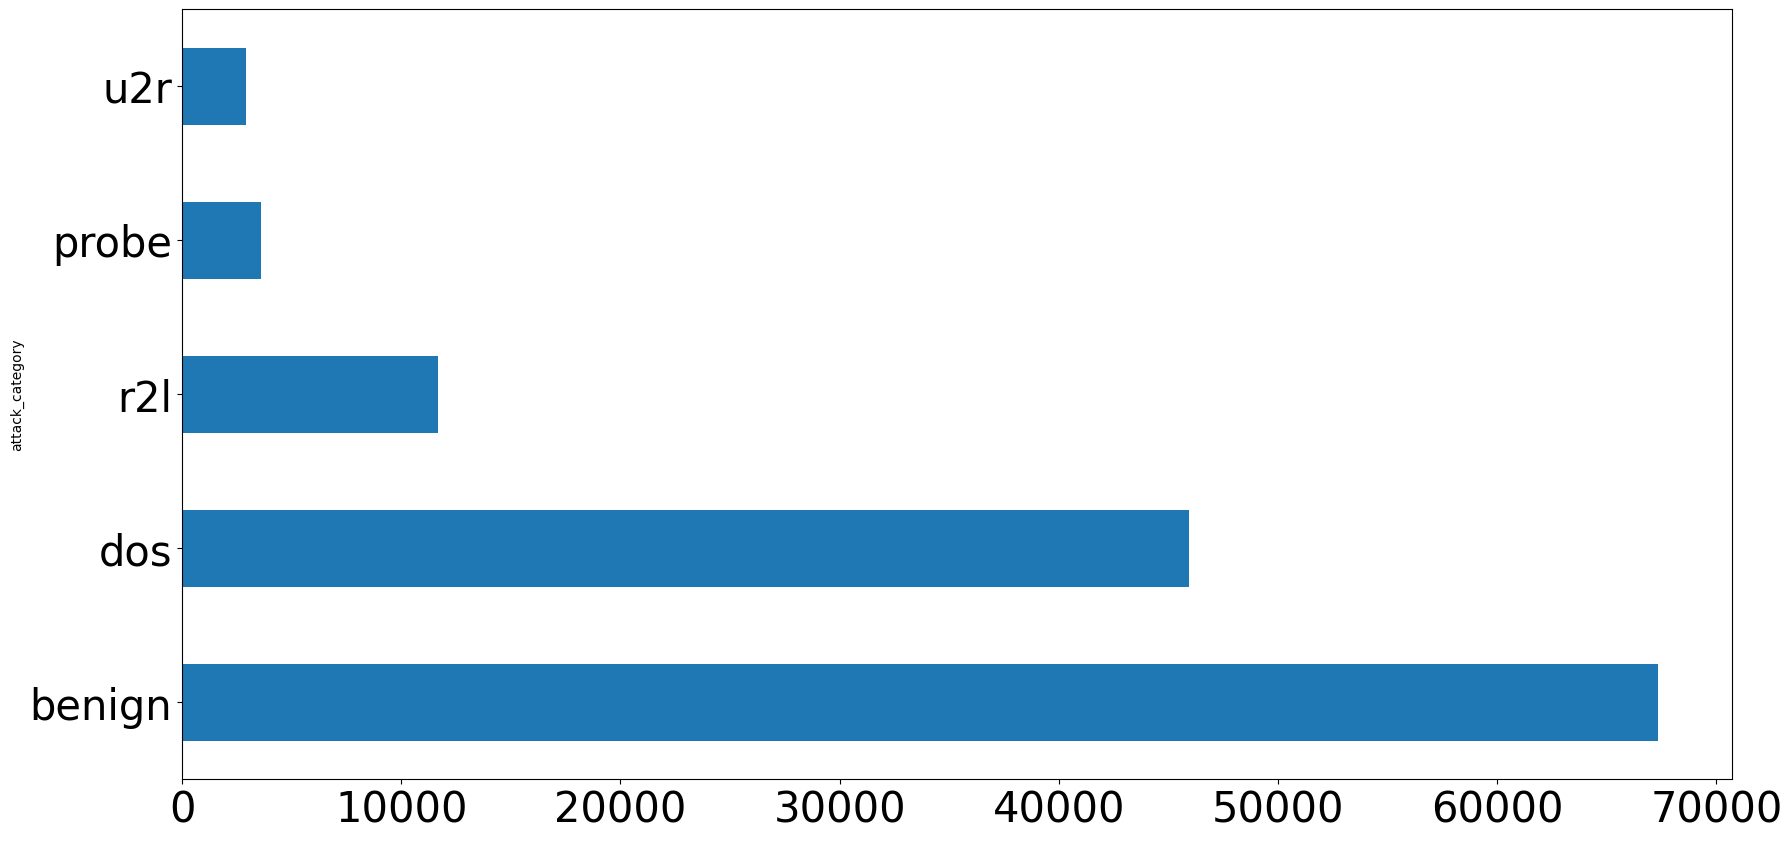

In [22]:
# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types


category = defaultdict(list)
category['benign'].append('normal')

with open('/content/drive/My Drive/uva1/nslkdd/training_attack_types.txt', 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v, k) for k in category for v in category[k])

train_df = pd.read_csv(train_file, names=header_names)

train_df['attack_category'] = train_df['attack_type'] \
    .map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis=1, inplace=True)

test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
    .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)

train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

train_attack_types.plot(kind='barh', figsize=(20, 10), fontsize=20)

train_attack_cats.plot(kind='barh', figsize=(20, 10), fontsize=30)

test_attack_types.plot(kind='barh', figsize=(20, 10), fontsize=15)

test_attack_cats.plot(kind='barh', figsize=(20, 10), fontsize=30)

In [26]:
# Let's take a look at the binary features
# By definition, all of these features should have a min of 0.0 and a max of 1.0
# execute the commands in console

train_df[binary_cols].describe().transpose()

# Wait a minute... the su_attempted column has a max value of 2.0?

train_df.groupby(['su_attempted']).size()

# Let's fix this discrepancy and assume that su_attempted=2 -> su_attempted=0

train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()
# Next, we notice that the num_outbound_cmds column only takes on one value!
print(train_df.columns)


# train_df.groupby(['num_outbound_cmds']).size()

# # Now, that's not a very useful feature - let's drop it from the dataset

# train_df.drop('num_outbound_cmds', axis=1, inplace=True)
# test_df.drop('num_outbound_cmds', axis=1, inplace=True)
# numeric_cols.remove('num_outbound_cmds')


Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'is_host_login', 'is_guest_login', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type',
       'attack_category'],
      dtype='object')


In [27]:
"""
Data Preparation

"""
train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category', 'attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category', 'attack_type'], axis=1)

'''# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k=30)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs
'''

combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# use this for catboost
x_train = train_x_raw
x_test = test_x_raw

# Store dummy variable feature names
dummy_variables = list(set(train_x) - set(combined_df_raw))

# execute the commands in console
train_x.describe()
train_x['duration'].describe()

# Experimenting with StandardScaler on the single 'duration' feature
durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

# Experimenting with MinMaxScaler on the single 'duration' feature

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

# Experimenting with RobustScaler on the single 'duration' feature

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

# Let's proceed with StandardScaler- Apply to all the numeric columns

standard_scaler = StandardScaler().fit(train_x[numeric_cols])

train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])

test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])

train_x.describe()

train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)

'''# transform the dataset
oversample = SMOTE()
train_x, train_Y = oversample.fit_resample(train_x, train_Y)'''

'# transform the dataset\noversample = SMOTE()\ntrain_x, train_Y = oversample.fit_resample(train_x, train_Y)'

In [30]:
"""
multi class classification using decision tree

"""

from sklearn.metrics import accuracy_score, precision_score, recall_score
# Decision Tree
def decision_tree_clf():
    print("------Decision Tree Classification-------")

    # build Decision Tree classifier
    classifier = DecisionTreeClassifier(random_state=17)

    # Train Classifier
    classifier.fit(train_x, train_Y)

    # predict
    pred_y = classifier.predict(test_x)

    # confusion matrix
    results = confusion_matrix(test_Y, pred_y)

    # error rate
    error = zero_one_loss(test_Y, pred_y)

    # print results
    print(results)
    print(error)
    # Accuracy
    accuracy = accuracy_score(test_Y, pred_y)

    # Precision
    precision = precision_score(test_Y, pred_y, average='weighted')

    # Recall
    recall = recall_score(test_Y, pred_y, average='weighted')

    # Error Rate
    error = zero_one_loss(test_Y, pred_y)

    # Print results
    print("Confusion Matrix:")
    print(results)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Error Rate:", error)
decision_tree_clf()


------Decision Tree Classification-------
[[9365   56  289    1    0]
 [1541 5998   97    0    0]
 [ 677  220 1526    0    0]
 [2278    1   14  277    4]
 [ 175    0    5    5   15]]
0.2378903477643719
Confusion Matrix:
[[9365   56  289    1    0]
 [1541 5998   97    0    0]
 [ 677  220 1526    0    0]
 [2278    1   14  277    4]
 [ 175    0    5    5   15]]
Accuracy: 0.7621096522356281
Precision: 0.8148668083524764
Recall: 0.7621096522356281
Error Rate: 0.2378903477643719
